In [1]:
import json
from Bio import SeqIO, Phylo, Seq
import pandas as pd
from string import digits
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

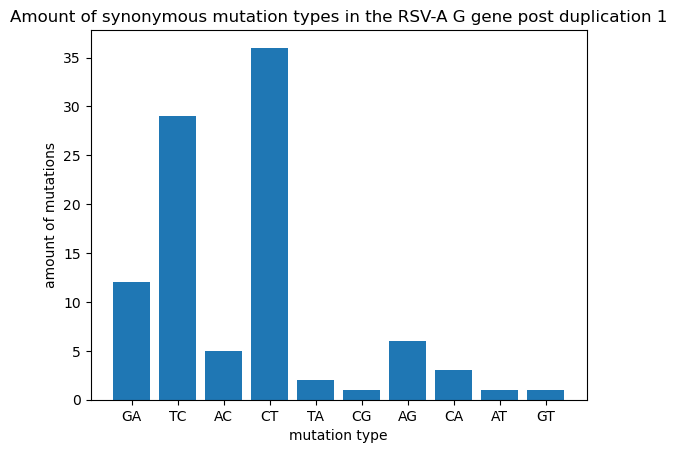

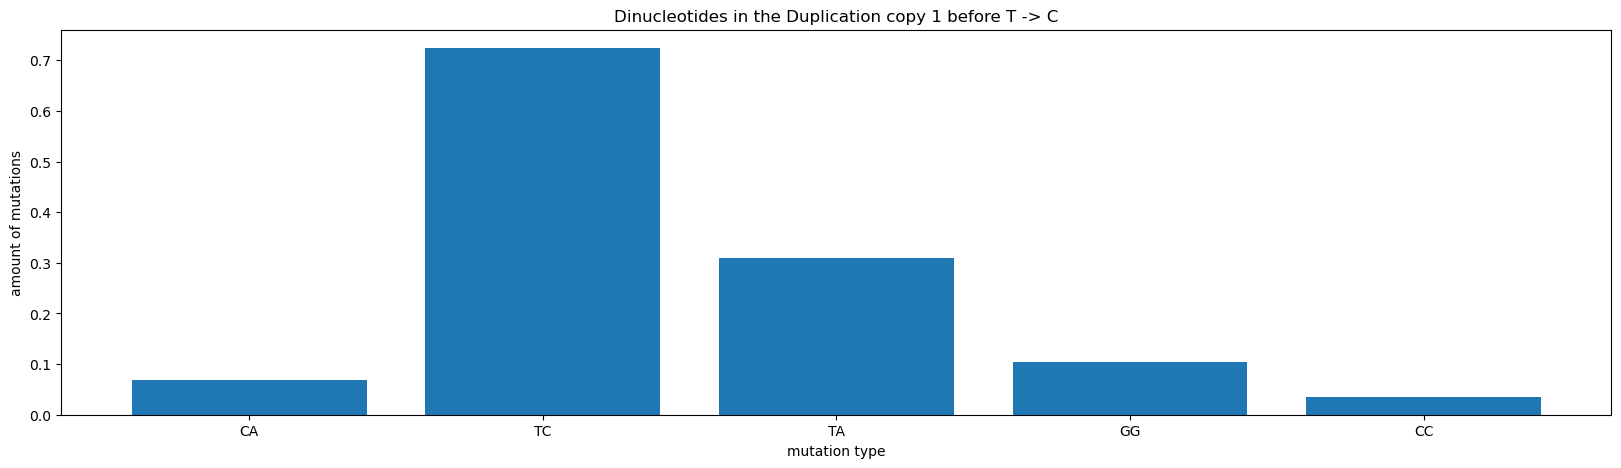

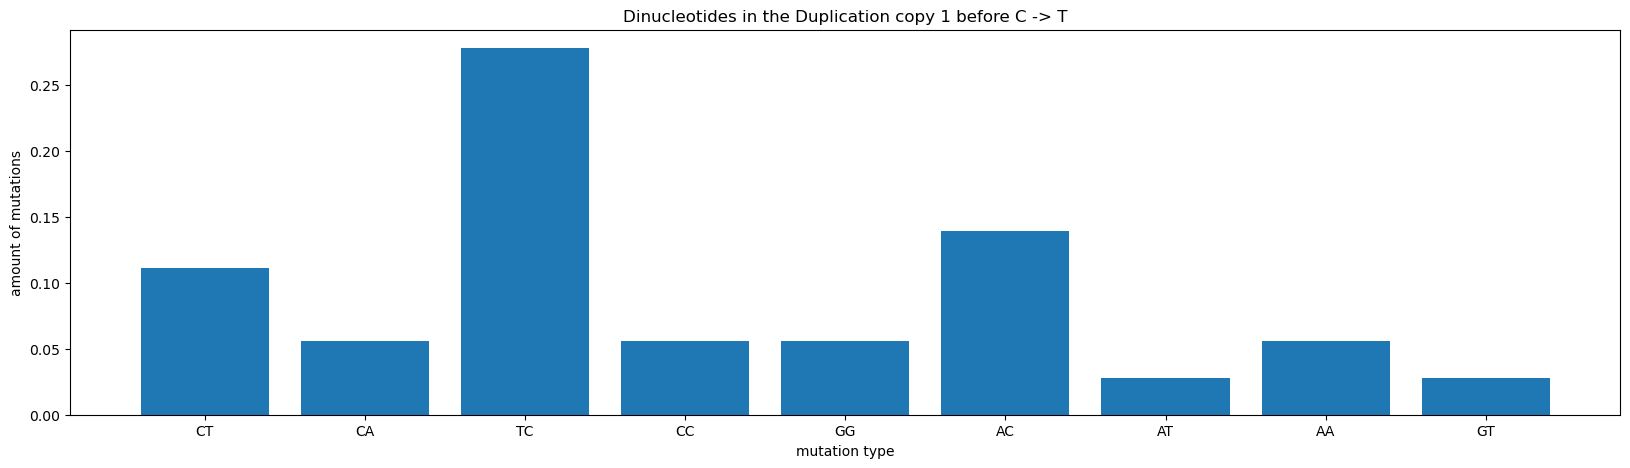

In [13]:
def separate_duplications(lengthofdupl):
    """
    Divides sequences from duplication file into preduplication, and postduplication copies 1 and 2
    By splitting the files into two parts based on duplication length
    
    inputs: length of duplication (72 for RSV-A and 60 for RSV-B)
            duplication file (fasta file containing aligned duplicated regions)
    outputs:
        - preduplication dictionary 
        - postduplication dictionary (first copy)
        -postduplication dictionary (second copy)
    
    """
    duplicationfile = SeqIO.parse("data/last_reconstruction.fasta", "fasta")
    preduplication, postduplication_1, postduplication_2 = (defaultdict(list) for i in range(3))
    for entry in duplicationfile:
        if '-' not in entry.seq:
            copy_1 = entry.seq[:int(lengthofdupl)][1:-2]
            copy_2 = entry.seq[int(lengthofdupl):][1:-2]
            for i in range(0, len(copy_1), 3):
                postduplication_1[entry.id].append(copy_1[i:i+3])
            for i in range(0, len(copy_2), 3):
                postduplication_2[entry.id].append(copy_2[i:i+3])
        else:
            preduplication_ = entry.seq.replace("-", "")
            if len(preduplication_)== int(lengthofdupl):
                preduplication_ = preduplication_[1:-2]
                for i in range(0, len(preduplication_), 3):
                    preduplication[entry.id].append(preduplication_[i:i+3])
    return(postduplication_1, postduplication_2, preduplication)


def recursive_mutations(treefile, copy):
    """
    Makes basic first reconstruction of common mutations moved to common ancestor. 
    Mutations are split into synonymous and nonsynonymous based on if they result in amino acid change or not. 

    inputs:
        - open newick tree file (rooted at midpoint)
        - copy: dictionary of sequences in a copy of the duplication
    outputs:
        - dictionary synonymous: rudimentary first reconstruction of the common mutations in the copy in dictionary form (synonymous)
        - dictionary nonsynonymous: same as above but nonsynonymous
    """
    synonymous_, nonsynonymous_ = (defaultdict(list) for i in range(2))
    for branch in treefile.get_nonterminals(order='postorder'):
        if branch.name in copy:
            for b in branch:
                if b.name in copy:
                    index = 0
                    for codon_branch, codon_b in zip(copy[branch.name], copy[b.name]):
                        if codon_branch != codon_b:
                            if Seq.translate(codon_branch) == Seq.translate(codon_b):
                                pos = 0
                                for char_branch, char_b in zip(codon_branch, codon_b):
                                    pos +=1
                                    if char_branch != char_b:
                                        entry_unsorted = f'{char_b}{char_branch}{pos+(index*3)}'
                                        synonymous_[b.name].append(str("".join(entry_unsorted[:2])+ entry_unsorted[2:]))
                            else:
                                pos = 0
                                for char_branch, char_b in zip(codon_branch, codon_b):
                                    pos +=1
                                    if char_branch != char_b:
                                        entry_unsorted = f'{char_b}{char_branch}{pos+(index*3)}'
                                        nonsynonymous_[b.name].append(str("".join(entry_unsorted[:2])+ entry_unsorted[2:]))
                        index+=1
    return(nonsynonymous_, synonymous_)

def refine_recursive(treefile, synonymous, nonsynonymous):
    """
    Refines the common mutation function described above. 
    Mutations present in multiple branches are moved further up the tree and exceptions due to sequencing errors are taken into account.

    inputs:
        dictionary synonymous (dictionary of branches and synonymous mutations)
        dictionary nonsynonymous (same as above but nonsynonymous)
        read nwk tree file rooted at midpoint, with the relevant branches

    outputs:
        dictionaries for synonymous and nonsynonymous common mutations.
    
    """
    for branch in treefile.get_nonterminals(order='postorder'):
        if branch.name in synonymous:
            for b in branch:
                if b.name in synonymous:
                    synonymous[b.name] = list(set(synonymous[b.name]).difference(set(synonymous[branch.name])))
        if branch.name in nonsynonymous:
            for b in branch:
                if b.name in synonymous:
                    nonsynonymous[b.name] = list(set(nonsynonymous[b.name]).difference(set(nonsynonymous[branch.name])))
    for branch in treefile.get_nonterminals(order='preorder'):
        sort_branch = []
        for e in nonsynonymous[branch.name]:
            sort_branch.append(str("".join(sorted(e[:2]+ e[2:]))))
        for b in branch:
            if b.name in nonsynonymous:
                sort_b = []
                for entry in nonsynonymous[b.name]:
                    sort_b.append(str("".join((entry[:2]+ entry[2:]))))
                nonsynonymous[b.name] = set(set(sort_b).difference(set(sort_branch)))
    return(nonsynonymous, synonymous)


def mutations(synonymous, nonsynonymous):
    """
    Returns locations of synonymous and nonsynonymous mutations in list format
    
    Inputs:
        synonymous mutation dictionary
        nonsynonymous mutation dictionary
    Outputs:
        - list of nonsynonymous mut location
        - list of synonymous mut location
    """
    syn_, nonsyn_, lst_s, lst_n = ([] for i in range(4))
    for i in synonymous.values():
        ls = list(i)
        for j in ls: lst_s.append(j)
    for item_ in lst_s: syn_.append(int(item_[2:]))
    for i in nonsynonymous.values():
        ls = list(i)
        numbers_ = []
        for it in ls:numbers_.append(it[2:])
        new_numbers_ = list(set(numbers_))
        for j in new_numbers_: lst_n.append(j)
    for item_ in lst_n: nonsyn_.append(int(item_))
    
    return(nonsyn_, syn_)

duplication_file = SeqIO.parse("data/last_reconstruction.fasta", 'fasta')
synonymous_one, nonsynonymous_one  = (defaultdict(list) for i in range(2))
tree_file  = Phylo.read("data/duplication/a_dupl_tree.nwk", "newick")
tree_file.root_at_midpoint()
tree_file.find_clades()


total_len = tree_file.total_branch_length()
seq_dict = dict()
for record in duplication_file:
    seq_dict[record.id] = record.seq
for branch in tree_file.get_nonterminals(order='preorder'):
    if pd.isna(branch.name) == False:
        if '-'*int(72) not in seq_dict[branch.name]:
            with_dupl = branch.total_branch_length()
            break
without_dupl = total_len-with_dupl

copy1, copy2, preduplication = separate_duplications(72)
nonsynonymous_1, synonymous_1 = recursive_mutations(tree_file, copy1)
nonsynonymous_2, synonymous_2 = recursive_mutations(tree_file, copy2)
nonsynonymous_pre, synonymous_pre = recursive_mutations(tree_file, preduplication)
nonsynonymous_1_refined, synonymous_1_refined = refine_recursive(tree_file, nonsynonymous_1, synonymous_1)
nonsynonymous_2_refined, synonymous_2_refined = refine_recursive(tree_file, nonsynonymous_2, synonymous_2)
nonsynonymous_pre_refined, synonymous_pre_refined = refine_recursive(tree_file, nonsynonymous_pre, synonymous_pre)
nonsyn_1, syn_1 = mutations(synonymous_1_refined, nonsynonymous_1_refined)
nonsyn_2, syn_2 = mutations(synonymous_2_refined, nonsynonymous_2_refined)
nonsyn_pre, syn_pre = mutations(synonymous_pre_refined, nonsynonymous_pre_refined)

syn_1_muts = []
for node, muts in synonymous_1_refined.items():
    for m in muts:
        if len(m) == 4:
            syn_1_muts.append(f'{m[:-2]}')
        else:
            syn_1_muts.append(f'{m[:-1]}')
for_graph = Counter(syn_1_muts)
plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A G gene post duplication 1")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")

# dinucleotides

all_dinucleotides, all_trinucleotides, all_tetranucleotides = ([] for i in range(3))
duplication_file = SeqIO.parse("data/last_reconstruction.fasta", 'fasta')
for entry in duplication_file:
    #print(entry)
    for i in synonymous_1_refined[entry.id]:
        location = int(i[2:])
        #print(i)
        #print(entry.seq[location-2: location+1])
        location_of_interest = int(i[2:])
        #print(entry.seq[location-3: location-1])
        #print((entry.seq[location-2: location+1]))
        dinucleotide_and_mut = entry.seq[location-2: location] + f'{i[1]}{i[0]}'
        trinucleotide_and_mut = entry.seq[location-3: location] + f'{i[1]}{i[0]}'
        tetranucleotide_and_mut = entry.seq[location-4: location] + f'{i[1]}{i[0]}'
        #print(dinucleotide_and_mut)
        all_dinucleotides.append(str(dinucleotide_and_mut))
        all_trinucleotides.append(str(trinucleotide_and_mut))
        all_tetranucleotides.append(str(tetranucleotide_and_mut))


gc_list, cg_list, ca_list, ct_list, ga_list, ag_list, tc_list, gt_list, at_list, ac_list, ta_list, tg_list = ([] for i in range(12))
ct_list_tri, tc_list_tri = ([] for i in range(2))
ct_list_tetra, tc_list_tetra = ([] for i in range(2))
for item_ in all_dinucleotides:
    if "-" not in item_:
        #if item_[2:] == "GC": gc_list.append(item_)
        #if item_[2:] == "CG": cg_list.append(item_)
        #if item_[2:] == "GA": ga_list.append(item_)
        #if item_[2:] == "AG": ag_list.append(item_)
        #if item_[2:] == "CA": ca_list.append(item_)
        if item_[2:] == "CT": ct_list.append(item_)
        if item_[2:] == "TC": tc_list.append(item_)
        #if item_[2:] == "GT": gt_list.append(item_)
        #if item_[2:] == "TG": tg_list.append(item_)
        #if item_[2:] == "AT": at_list.append(item_)
        #if item_[2:] == "TA": ta_list.append(item_)
        #if item_[2:] == "AC": ac_list.append(item_)
        #if item_[2:] == "AG": ag_list.append(item_)
for item_ in all_trinucleotides:
    if "-" not in item_:
        if item_[3:] == "CT": ct_list_tri.append(item_)
        if item_[3:] == "TC": tc_list_tri.append(item_)
for item_ in all_tetranucleotides:
    if "-" not in item_:
        if item_[4:] == "CT": ct_list_tetra.append(item_)
        if item_[4:] == "TC": tc_list_tetra.append(item_)
dinucl_counter = Counter(all_dinucleotides)
trinucl_counter = Counter(all_trinucleotides)
tetranucl_counter = Counter(all_tetranucleotides)
#gc_counter = Counter(gc_list)
#cg_counter = Counter(cg_list)
#ca_counter = Counter(ca_list)
ct_counter = Counter(ct_list)
#ga_counter = Counter(ga_list)
#ag_counter = Counter(ag_list)
tc_counter = Counter(tc_list)
tc_count_tr = Counter(tc_list_tri)
ct_count_tr = Counter(ct_list_tri)
ct_count_te = Counter(ct_list_tetra)
tc_count_te = Counter(tc_list_tetra)
#gt_counter = Counter(gt_list)
#at_counter = Counter(at_list)
#ac_counter = Counter(ac_list)
#ta_counter = Counter(ta_list)
#tg_counter = Counter(tg_list)

#counters = [gc_counter, cg_counter, ca_counter, ct_counter,ga_counter, ag_counter, tc_counter, gt_counter, at_counter, ac_counter, ta_counter, tg_counter]
#type_= ["GC", "CG", "CA", "CT", "GA", "AG", "TC", "GT", "AT", "AC", "TA", "TG"]
counters = [tc_counter, ct_counter]
type_ = ["TC", "CT"]
for (i,counter_), typ in zip(enumerate(counters), type_):
    plt_1 = plt.figure(figsize=(20, 5))
    for mut, freq in for_graph.items():
        if mut == typ:
            values_weighed = [val/freq for val in counter_.values()]
            dinucl = [key[:2] for key in counter_.keys()]
            plt.bar(dinucl, values_weighed)
            plt.title(f"Dinucleotides in the Duplication copy 1 before {typ[0]} -> {typ[1]}")
            plt.xlabel("mutation type")
            plt.ylabel("amount of mutations")
plt.show()

TC
CT


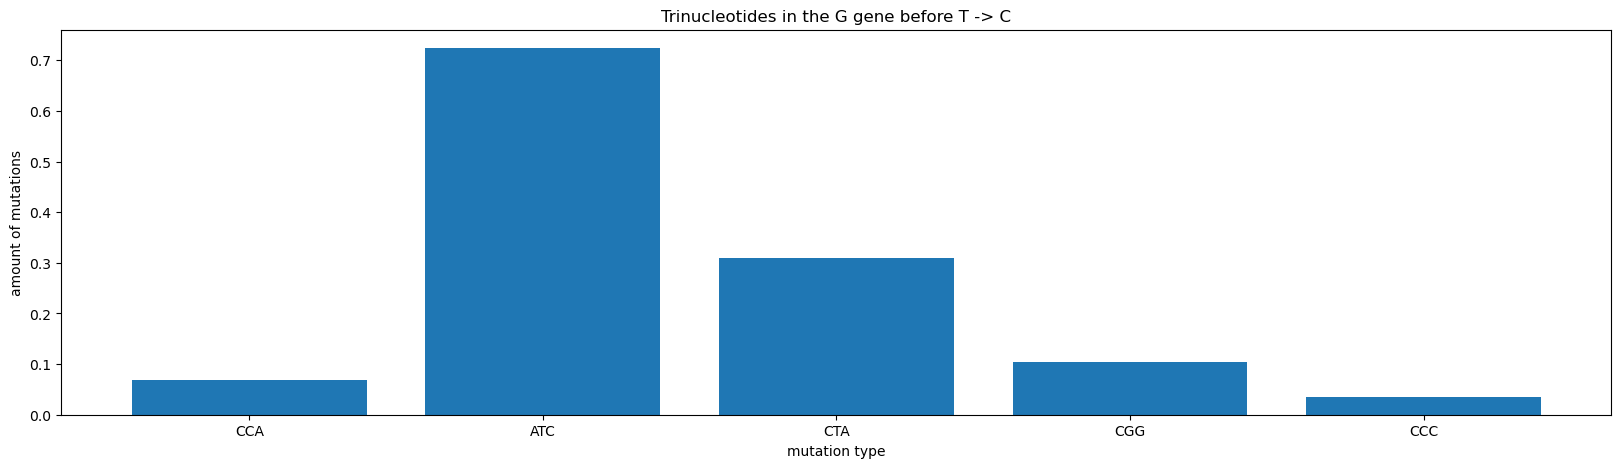

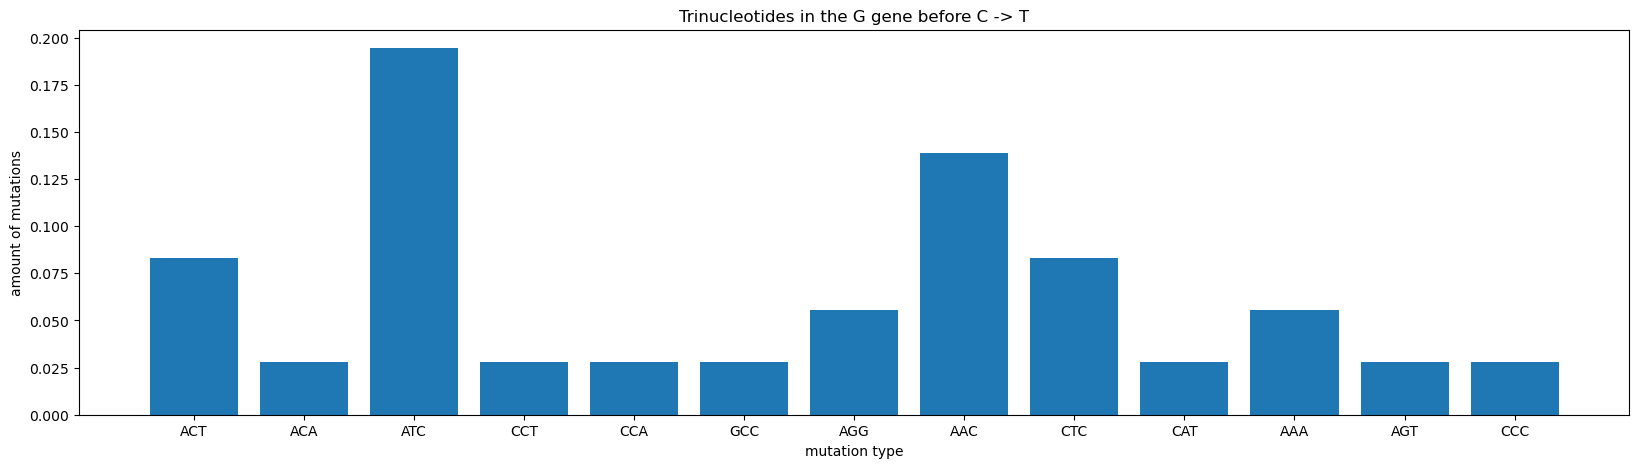

In [14]:
counters = [tc_count_tr, ct_count_tr]
type_ = ["TC", "CT"]
for counter_, typ in zip(counters, type_):
    plt_1 = plt.figure(figsize=(20, 5))
    for mut, freq in for_graph.items():
        if mut == typ:
            values_weighed = [val/freq for val in counter_.values()]
            dinucl = [key[:3] for key in counter_.keys()]
            plt.bar(dinucl, values_weighed)
            plt.title(f"Trinucleotides in the G gene before {typ[0]} -> {typ[1]}")
            plt.xlabel("mutation type")
            plt.ylabel("amount of mutations")
plt.show()

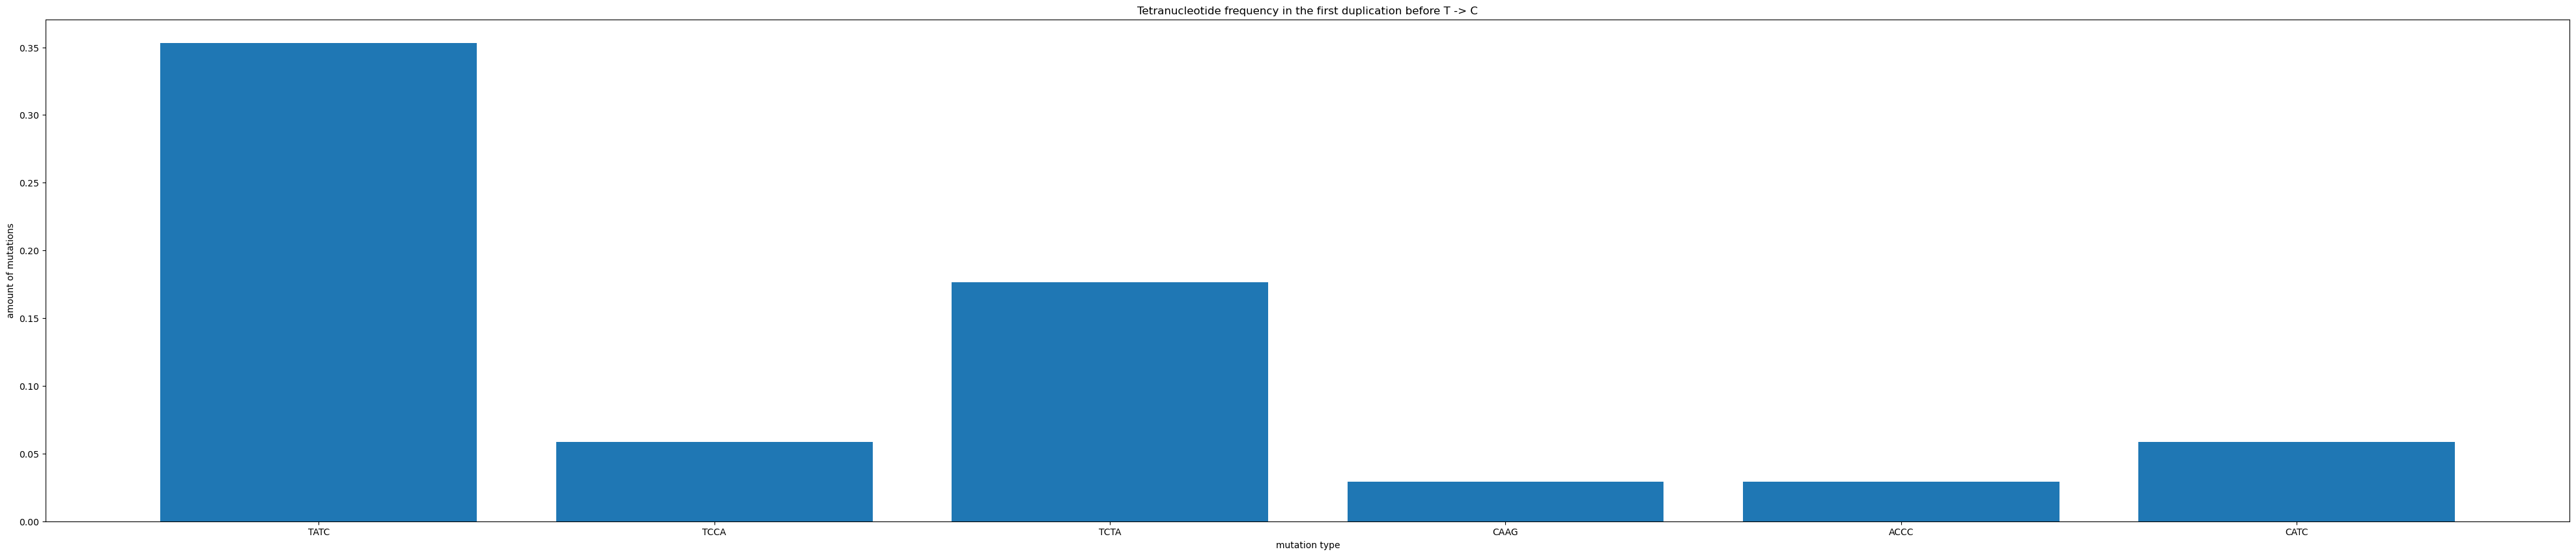

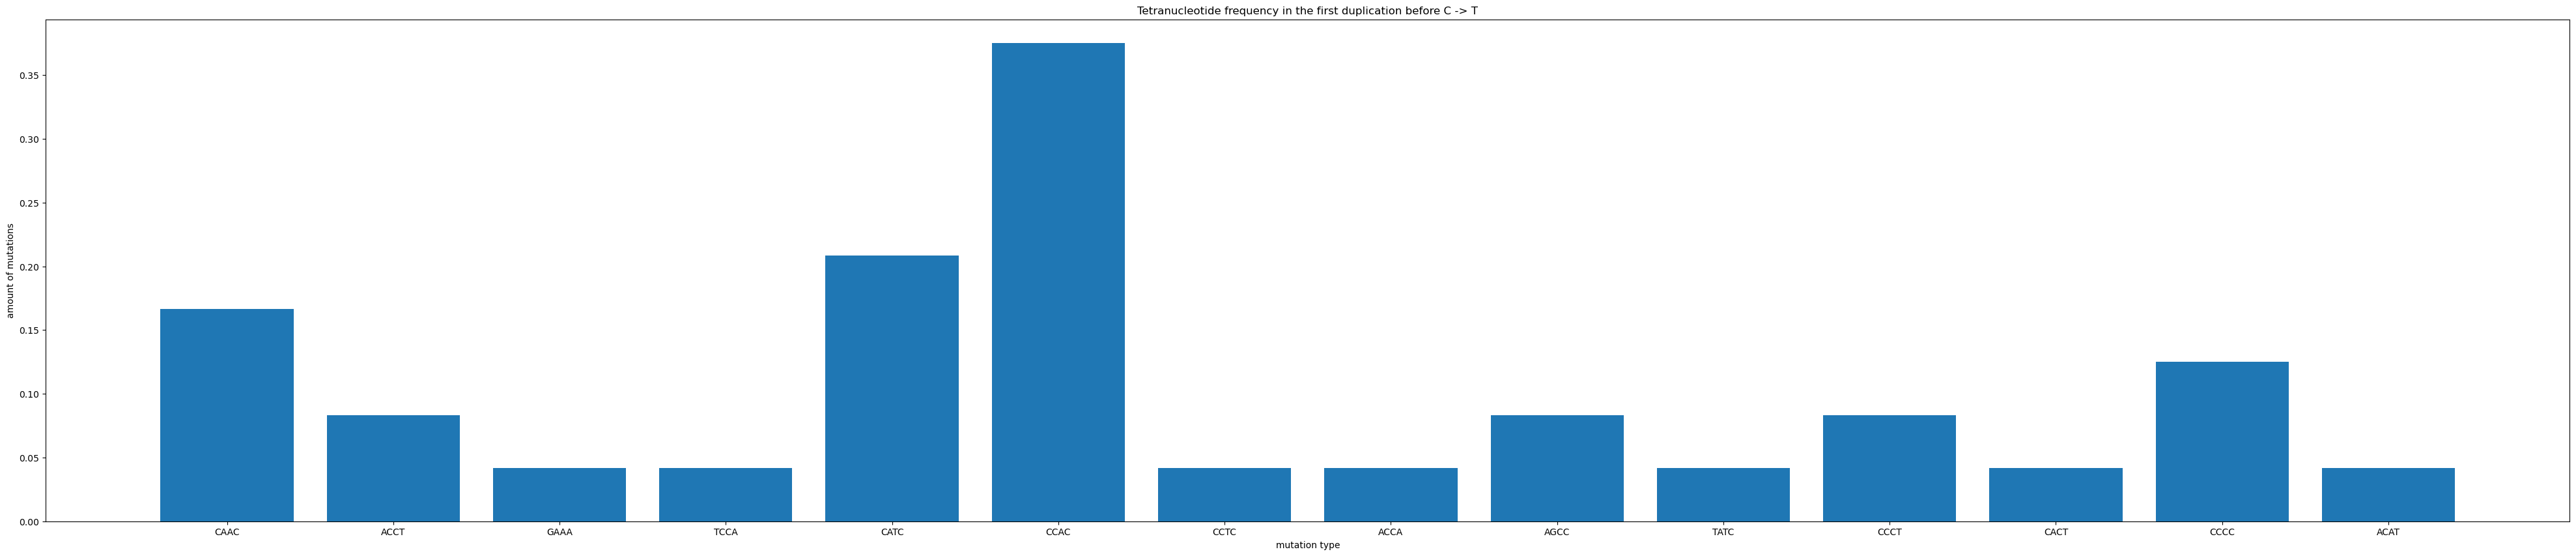

In [19]:
counters = [tc_count_te, ct_count_te]
type_ = ["TC", "CT"]
for counter_, typ in zip(counters, type_):
    plt_1 = plt.figure(figsize=(50, 10))
    for mut, freq in for_graph.items():
        if mut == typ:
            values_weighed = [val/freq for val in counter_.values()]
            dinucl = [key[:4] for key in counter_.keys()]
            plt.bar(dinucl, values_weighed)
            plt.title(f"Tetranucleotide frequency in the first duplication before {typ[0]} -> {typ[1]}")
            plt.xlabel("mutation type")
            plt.ylabel("amount of mutations")
plt.show()

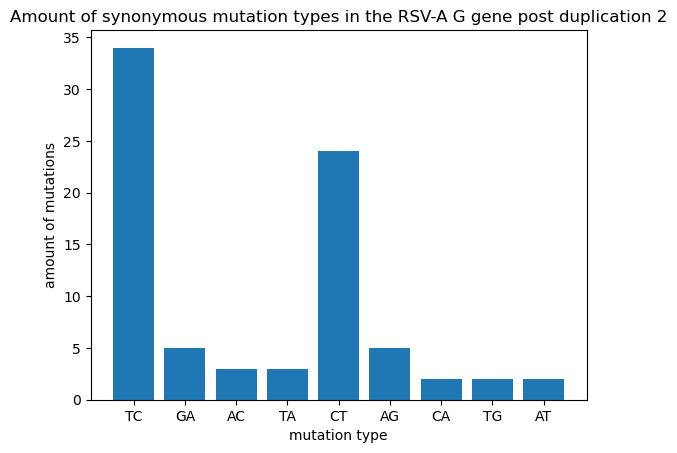

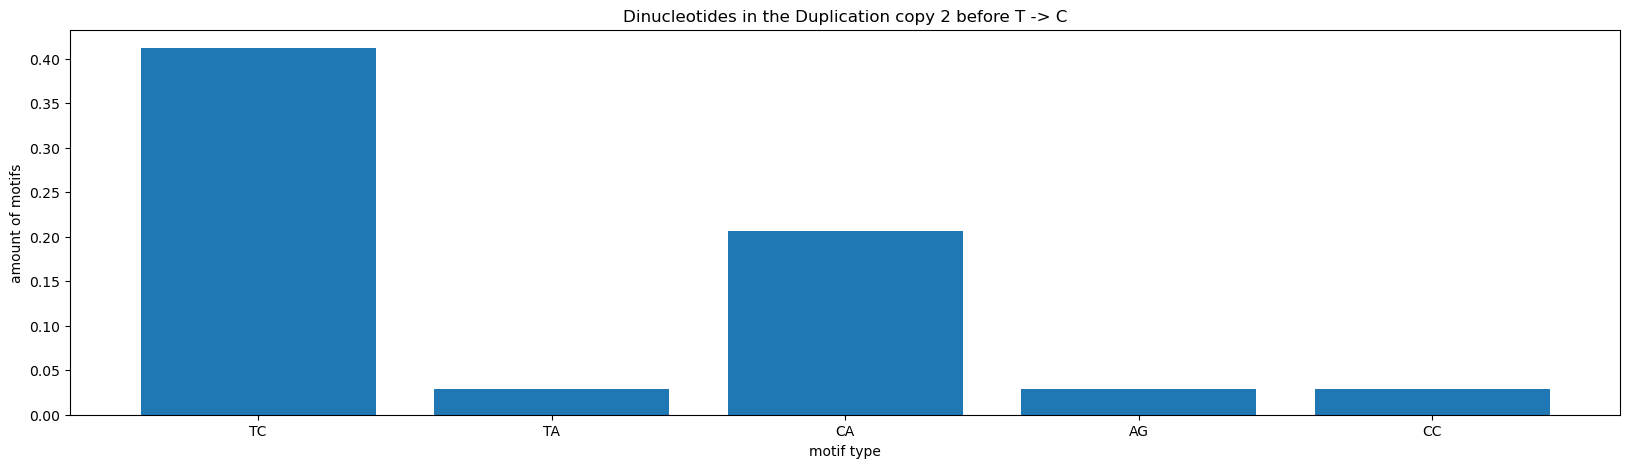

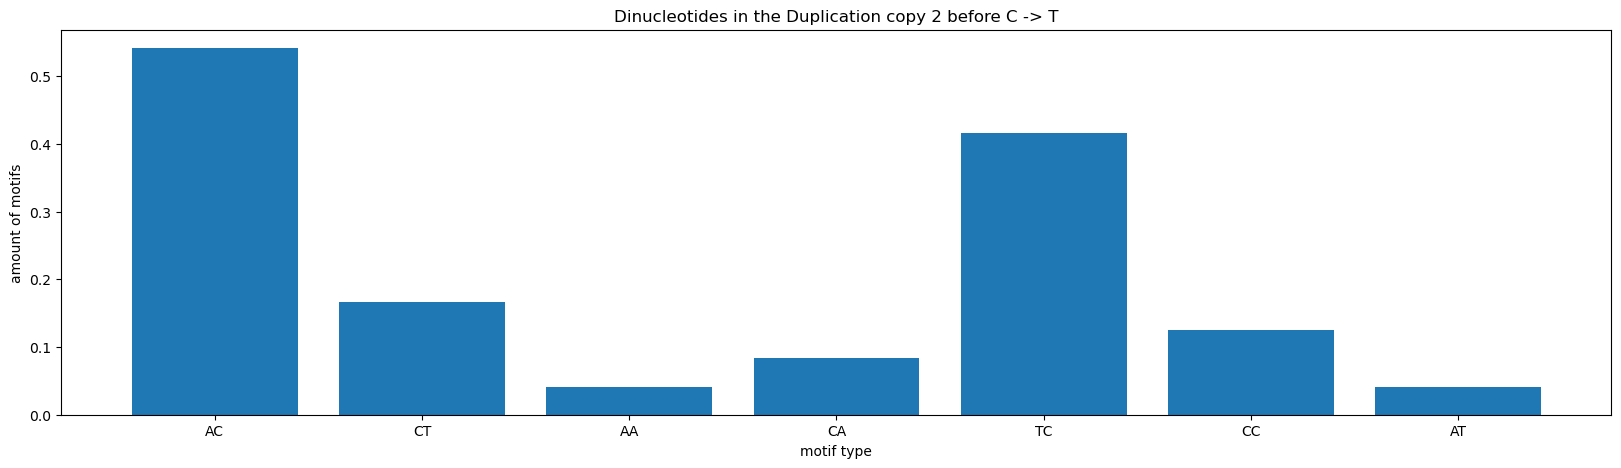

In [52]:
##DUPLICATION 2


syn_2_muts = []
for node, muts in synonymous_2_refined.items():
    for m in muts:
        if len(m) == 4:
            syn_2_muts.append(f'{m[:-2]}')
        else:
            syn_2_muts.append(f'{m[:-1]}')
for_graph = Counter(syn_2_muts)
plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A G gene post duplication 2")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")

# dinucleotides

all_dinucleotides, all_trinucleotides, all_tetranucleotides = ([] for i in range(3))
duplication_file = SeqIO.parse("data/last_reconstruction.fasta", 'fasta')
for entry in duplication_file:
    if '---' not in entry.seq:
        for i in synonymous_2_refined[entry.id]:
            location = int(i[2:])+72
            #print(i)
            #print(entry.seq[location-2: location+1])
            location_of_interest = int(i[2:])
            #print(entry.seq[location-3: location-1])
            #print((entry.seq[location-2: location+1]))
            dinucleotide_and_mut = entry.seq[location-2: location] + f'{i[1]}{i[0]}'
            trinucleotide_and_mut = entry.seq[location-3: location] + f'{i[1]}{i[0]}'
            tetranucleotide_and_mut = entry.seq[location-4: location] + f'{i[1]}{i[0]}'
            #print(dinucleotide_and_mut)
            all_dinucleotides.append(str(dinucleotide_and_mut))
            all_trinucleotides.append(str(trinucleotide_and_mut))
            all_tetranucleotides.append(str(tetranucleotide_and_mut))


gc_list, cg_list, ca_list, ct_list, ga_list, ag_list, tc_list, gt_list, at_list, ac_list, ta_list, tg_list = ([] for i in range(12))
ct_list_tri, tc_list_tri = ([] for i in range(2))
ct_list_tetra, tc_list_tetra = ([] for i in range(2))
for item_ in all_dinucleotides:
    if "-" not in item_:
        #if item_[2:] == "GC": gc_list.append(item_)
        #if item_[2:] == "CG": cg_list.append(item_)
        #if item_[2:] == "GA": ga_list.append(item_)
        #if item_[2:] == "AG": ag_list.append(item_)
        #if item_[2:] == "CA": ca_list.append(item_)
        if item_[2:] == "CT": ct_list.append(item_)
        if item_[2:] == "TC": tc_list.append(item_)
        #if item_[2:] == "GT": gt_list.append(item_)
        #if item_[2:] == "TG": tg_list.append(item_)
        #if item_[2:] == "AT": at_list.append(item_)
        #if item_[2:] == "TA": ta_list.append(item_)
        #if item_[2:] == "AC": ac_list.append(item_)
        #if item_[2:] == "AG": ag_list.append(item_)
for item_ in all_trinucleotides:
    if "-" not in item_:
        if item_[3:] == "CT": ct_list_tri.append(item_)
        if item_[3:] == "TC": tc_list_tri.append(item_)
for item_ in all_tetranucleotides:
    if "-" not in item_:
        if item_[4:] == "CT": ct_list_tetra.append(item_)
        if item_[4:] == "TC": tc_list_tetra.append(item_)
dinucl_counter = Counter(all_dinucleotides)
trinucl_counter = Counter(all_trinucleotides)
tetranucl_counter = Counter(all_tetranucleotides)
#gc_counter = Counter(gc_list)
#cg_counter = Counter(cg_list)
#ca_counter = Counter(ca_list)
ct_counter = Counter(ct_list)
#ga_counter = Counter(ga_list)
#ag_counter = Counter(ag_list)
tc_counter = Counter(tc_list)
tc_count_tr = Counter(tc_list_tri)
ct_count_tr = Counter(ct_list_tri)
ct_count_te = Counter(ct_list_tetra)
tc_count_te = Counter(tc_list_tetra)
#gt_counter = Counter(gt_list)
#at_counter = Counter(at_list)
#ac_counter = Counter(ac_list)
#ta_counter = Counter(ta_list)
#tg_counter = Counter(tg_list)

#counters = [gc_counter, cg_counter, ca_counter, ct_counter,ga_counter, ag_counter, tc_counter, gt_counter, at_counter, ac_counter, ta_counter, tg_counter]
#type_= ["GC", "CG", "CA", "CT", "GA", "AG", "TC", "GT", "AT", "AC", "TA", "TG"]
counters = [tc_counter, ct_counter]
type_ = ["TC", "CT"]
for (i,counter_), typ in zip(enumerate(counters), type_):
    plt_1 = plt.figure(figsize=(20, 5))
    for mut, freq in for_graph.items():
        if mut == typ:
            values_weighed = [val/freq for val in counter_.values()]
            dinucl = [key[:2] for key in counter_.keys()]
            plt.bar(dinucl, values_weighed)
            plt.title(f"Dinucleotides in the Duplication copy 2 before {typ[0]} -> {typ[1]}")
            plt.xlabel("motif type")
            plt.ylabel("amount of motifs")
plt.show()

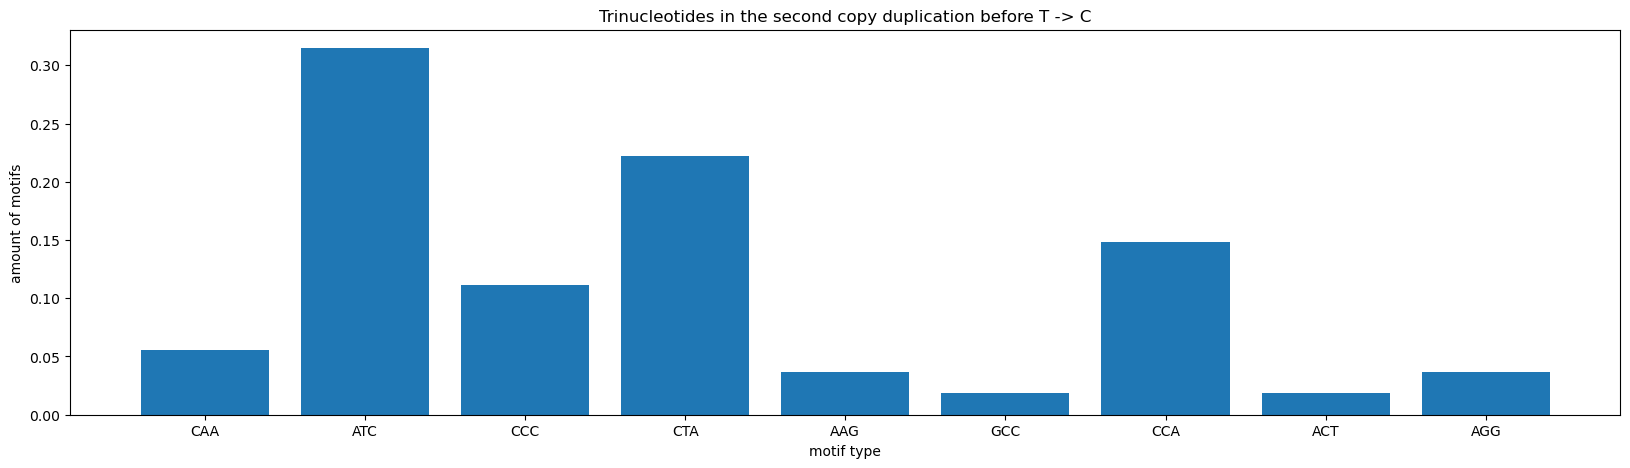

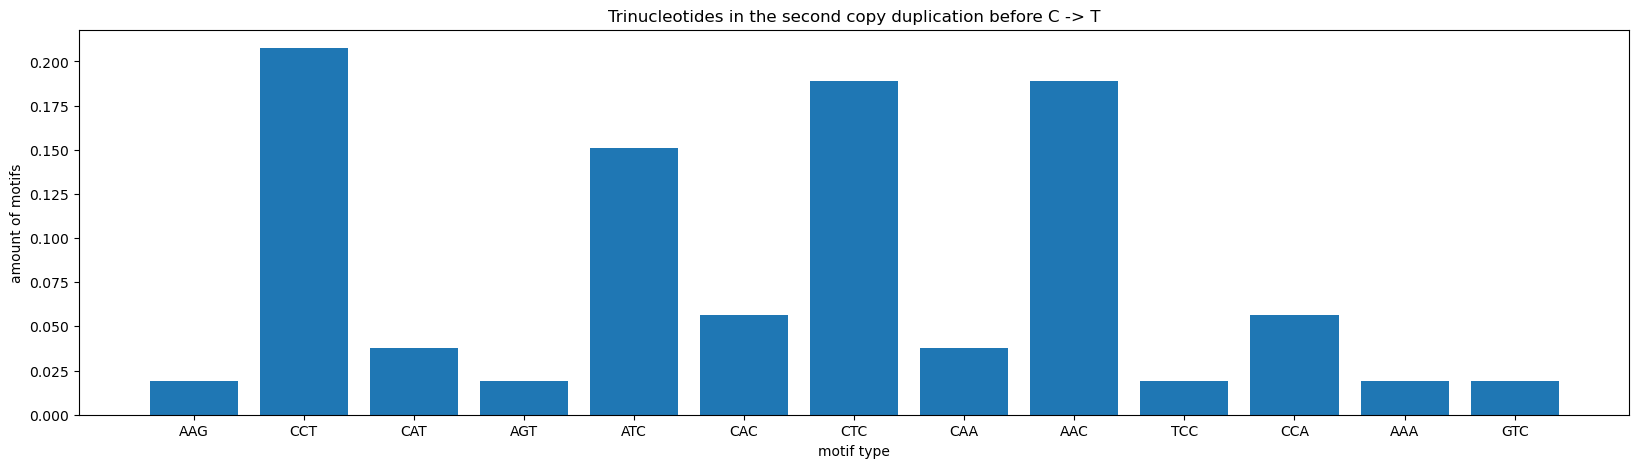

In [51]:
counters = [tc_count_tr, ct_count_tr]
type_ = ["TC", "CT"]
for counter_, typ in zip(counters, type_):
    plt_1 = plt.figure(figsize=(20, 5))
    for mut, freq in for_graph.items():
        if mut == typ:
            values_weighed = [val/freq for val in counter_.values()]
            dinucl = [key[:3] for key in counter_.keys()]
            plt.bar(dinucl, values_weighed)
            plt.title(f"Trinucleotides in the second copy duplication before {typ[0]} -> {typ[1]}")
            plt.xlabel("motif type")
            plt.ylabel("amount of motifs")
plt.show()

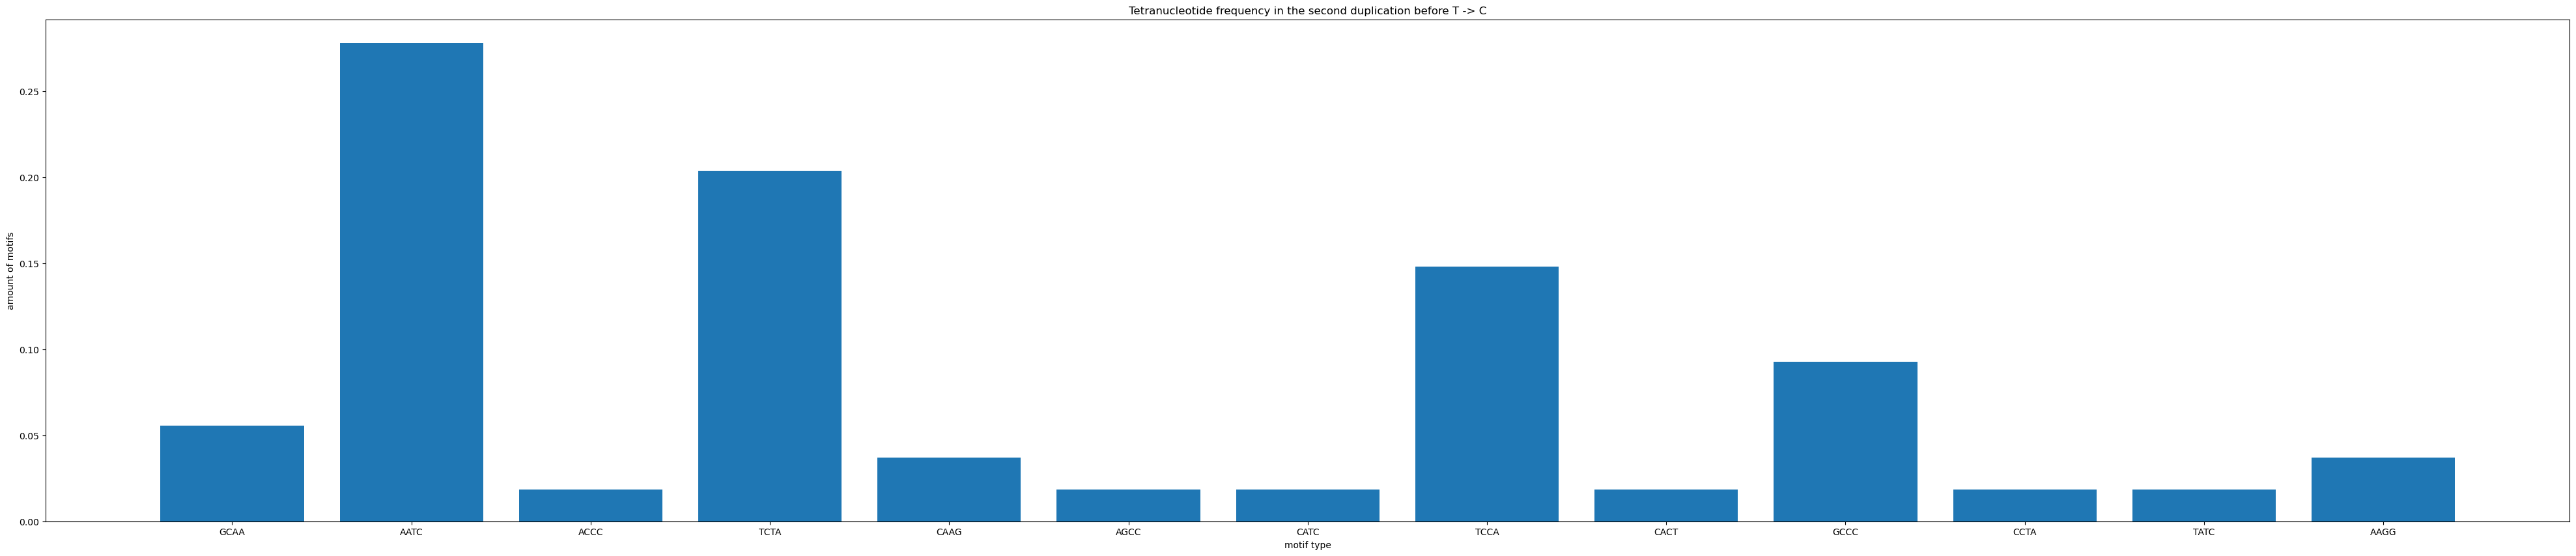

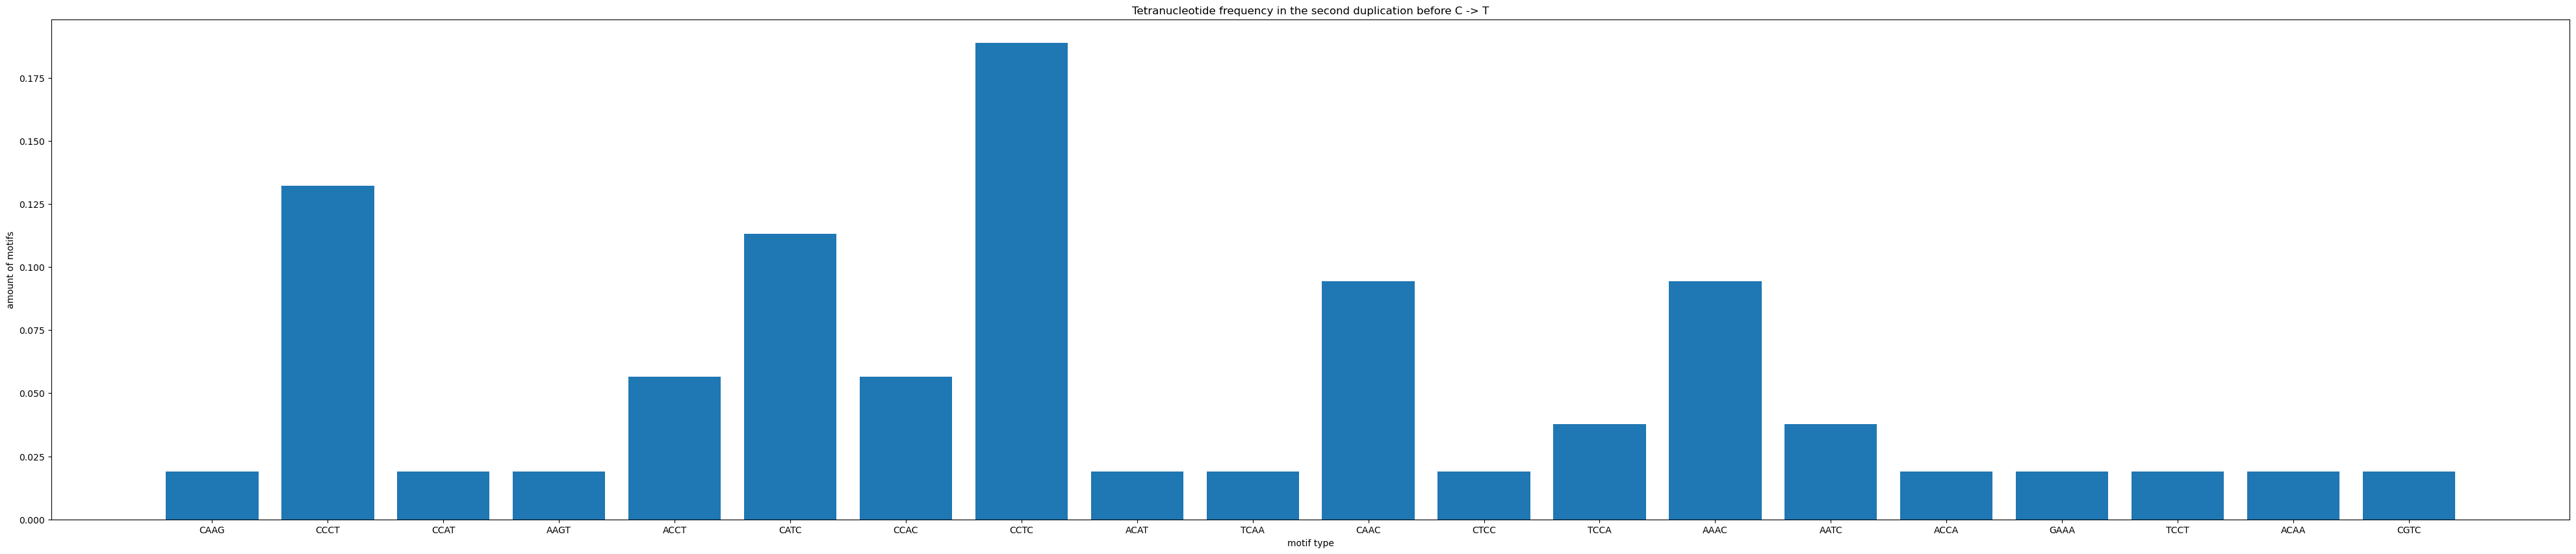

In [50]:
counters = [tc_count_te, ct_count_te]
type_ = ["TC", "CT"]
for counter_, typ in zip(counters, type_):
    plt_1 = plt.figure(figsize=(50, 10))
    for mut, freq in for_graph.items():
        if mut == typ:
            values_weighed = [val/freq for val in counter_.values()]
            dinucl = [key[:4] for key in counter_.keys()]
            plt.bar(dinucl, values_weighed)
            plt.title(f"Tetranucleotide frequency in the second duplication before {typ[0]} -> {typ[1]}")
            plt.xlabel("motif type")
            plt.ylabel("amount of motifs")
plt.show()

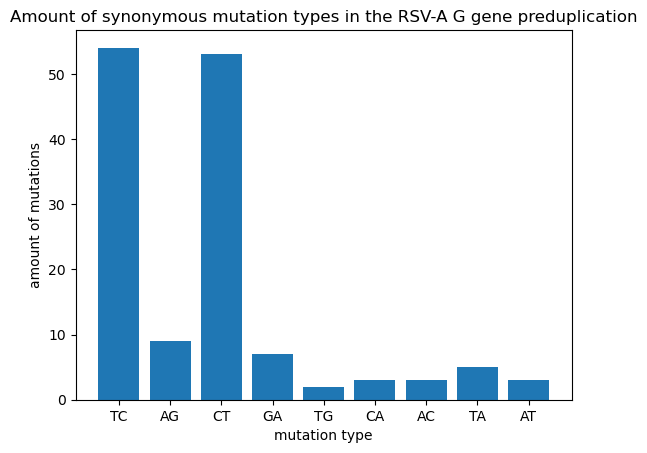

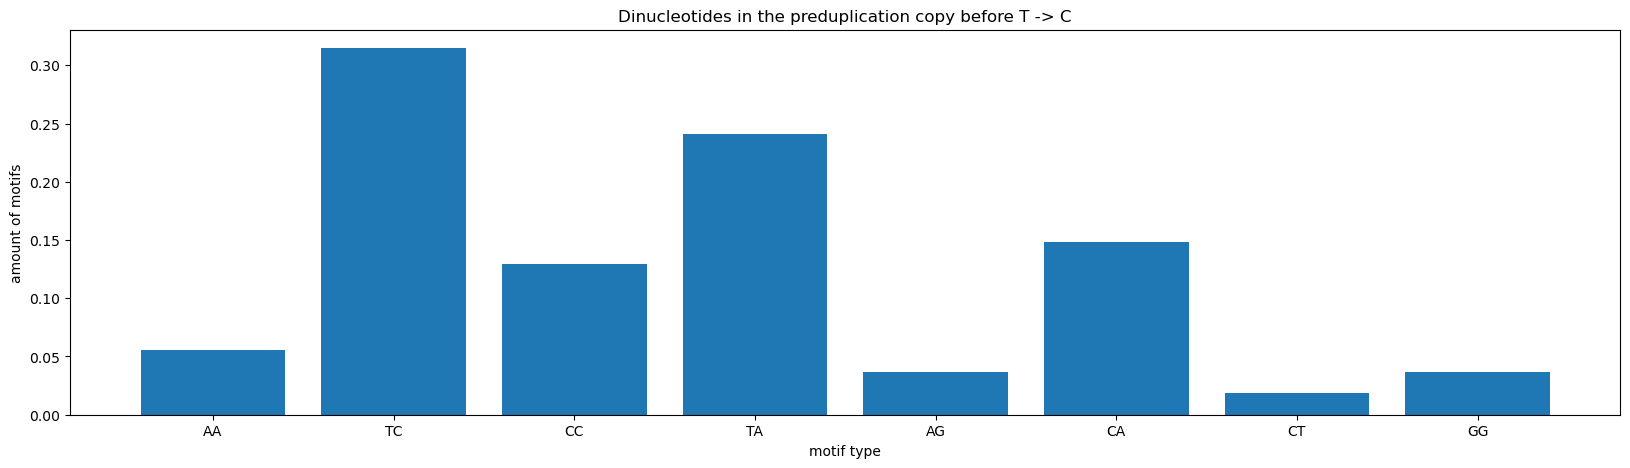

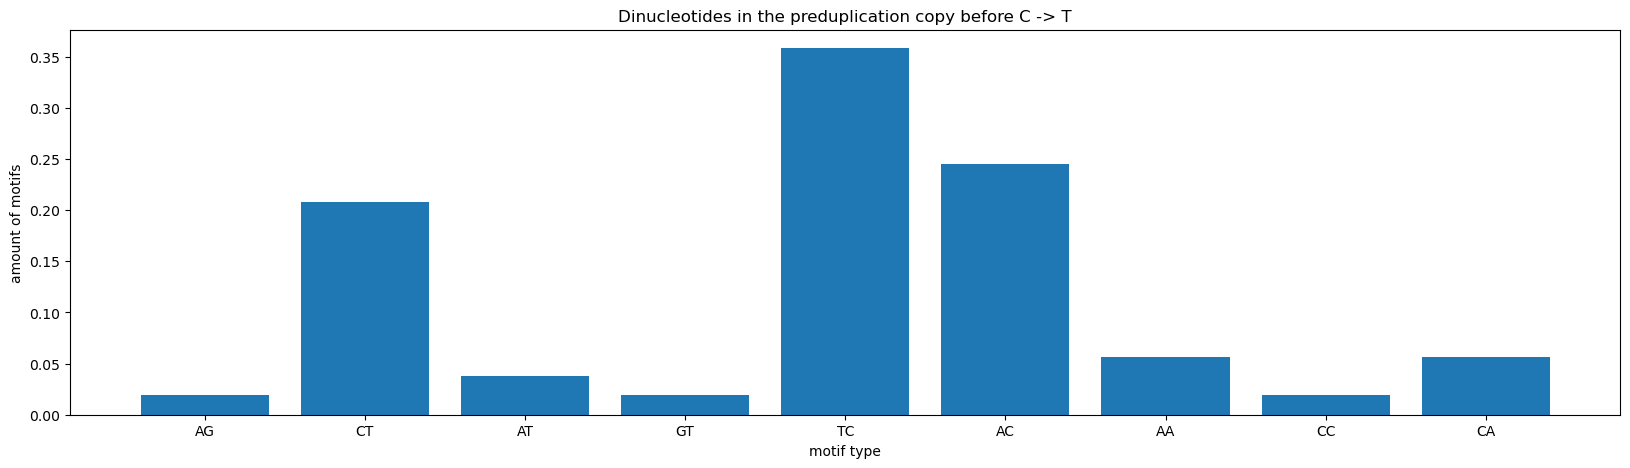

In [49]:
##PREDUPLICATION

syn_pre_muts = []
for node, muts in synonymous_pre_refined.items():
    for m in muts:
        if '-' and 'N' not in m:
            if len(m) == 4:
                syn_pre_muts.append(f'{m[:-2]}')
            else:
                syn_pre_muts.append(f'{m[:-1]}')
for_graph = Counter(syn_pre_muts)

plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A G gene preduplication")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")

# dinucleotides

all_dinucleotides, all_trinucleotides, all_tetranucleotides = ([] for i in range(3))
duplication_file = SeqIO.parse("data/last_reconstruction.fasta", 'fasta')
for entry in duplication_file:
    if '-'*72 in entry.seq:
        for i in synonymous_pre_refined[entry.id]:
            location = int(i[2:])+72
            #print(i)
            #print(entry.seq[location-2: location+1])
            #print(entry.seq[location-3: location-1])
            #print((entry.seq[location-2: location+1]))
            dinucleotide_and_mut = entry.seq[location-2: location] + f'{i[1]}{i[0]}'
            trinucleotide_and_mut = entry.seq[location-3: location] + f'{i[1]}{i[0]}'
            tetranucleotide_and_mut = entry.seq[location-4: location] + f'{i[1]}{i[0]}'
            if 'N' not in dinucleotide_and_mut:
                all_dinucleotides.append(str(dinucleotide_and_mut))
            if 'N' not in trinucleotide_and_mut:
                all_trinucleotides.append(str(trinucleotide_and_mut))
            if 'N' not in tetranucleotide_and_mut:
                all_tetranucleotides.append(str(tetranucleotide_and_mut))


gc_list, cg_list, ca_list, ct_list, ga_list, ag_list, tc_list, gt_list, at_list, ac_list, ta_list, tg_list = ([] for i in range(12))
ct_list_tri, tc_list_tri = ([] for i in range(2))
ct_list_tetra, tc_list_tetra = ([] for i in range(2))
for item_ in all_dinucleotides:
    if "-" not in item_:
        #if item_[2:] == "GC": gc_list.append(item_)
        #if item_[2:] == "CG": cg_list.append(item_)
        #if item_[2:] == "GA": ga_list.append(item_)
        #if item_[2:] == "AG": ag_list.append(item_)
        #if item_[2:] == "CA": ca_list.append(item_)
        if item_[2:] == "CT": ct_list.append(item_)
        if item_[2:] == "TC": tc_list.append(item_)
        #if item_[2:] == "GT": gt_list.append(item_)
        #if item_[2:] == "TG": tg_list.append(item_)
        #if item_[2:] == "AT": at_list.append(item_)
        #if item_[2:] == "TA": ta_list.append(item_)
        #if item_[2:] == "AC": ac_list.append(item_)
        #if item_[2:] == "AG": ag_list.append(item_)
for item_ in all_trinucleotides:
    if "-" not in item_:
        if item_[3:] == "CT": ct_list_tri.append(item_)
        if item_[3:] == "TC": tc_list_tri.append(item_)
for item_ in all_tetranucleotides:
    if "-" not in item_:
        if item_[4:] == "CT": ct_list_tetra.append(item_)
        if item_[4:] == "TC": tc_list_tetra.append(item_)
dinucl_counter = Counter(all_dinucleotides)
trinucl_counter = Counter(all_trinucleotides)
tetranucl_counter = Counter(all_tetranucleotides)
#gc_counter = Counter(gc_list)
#cg_counter = Counter(cg_list)
#ca_counter = Counter(ca_list)
ct_counter = Counter(ct_list)
#ga_counter = Counter(ga_list)
#ag_counter = Counter(ag_list)
tc_counter = Counter(tc_list)
tc_count_tr = Counter(tc_list_tri)
ct_count_tr = Counter(ct_list_tri)
ct_count_te = Counter(ct_list_tetra)
tc_count_te = Counter(tc_list_tetra)
#gt_counter = Counter(gt_list)
#at_counter = Counter(at_list)
#ac_counter = Counter(ac_list)
#ta_counter = Counter(ta_list)
#tg_counter = Counter(tg_list)

#counters = [gc_counter, cg_counter, ca_counter, ct_counter,ga_counter, ag_counter, tc_counter, gt_counter, at_counter, ac_counter, ta_counter, tg_counter]
#type_= ["GC", "CG", "CA", "CT", "GA", "AG", "TC", "GT", "AT", "AC", "TA", "TG"]
counters = [tc_counter, ct_counter]
type_ = ["TC", "CT"]
for counter_, typ in zip(counters, type_):
    plt_1 = plt.figure(figsize=(20, 5))
    for mut, freq in for_graph.items():
        if mut == typ:
            values_weighed = [val/freq for val in counter_.values()]
            dinucl = [key[:2] for key in counter_.keys()]
            plt.bar(dinucl, values_weighed)
            plt.title(f"Dinucleotides in the preduplication copy before {typ[0]} -> {typ[1]}")
            plt.xlabel("motif type")
            plt.ylabel("amount of motifs")
plt.show()

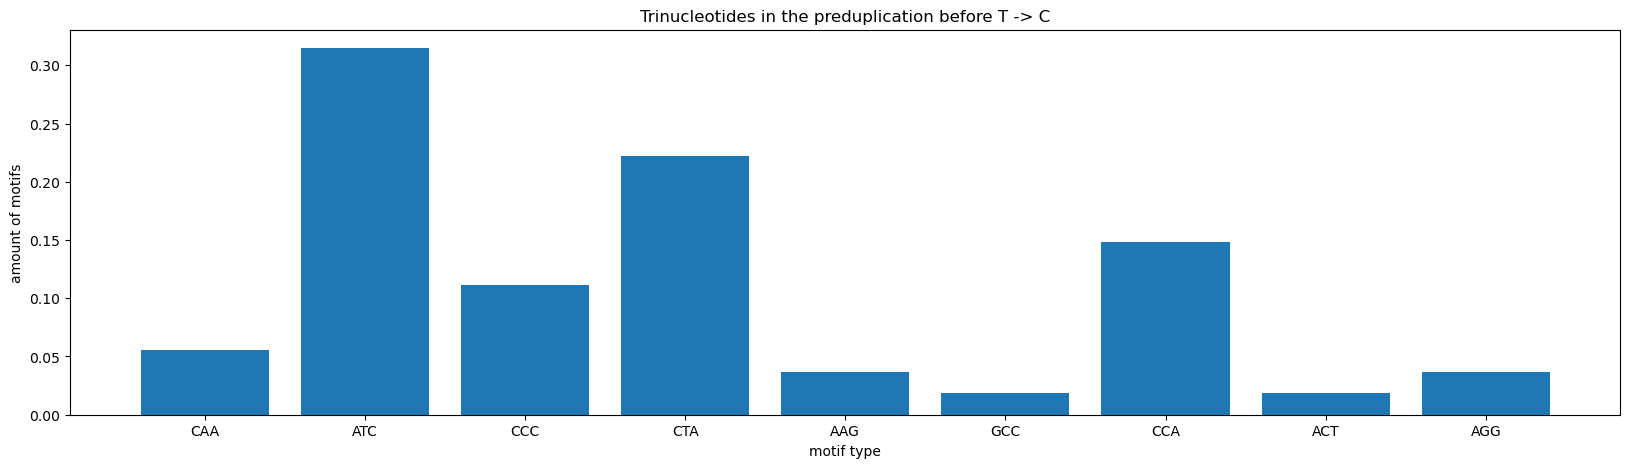

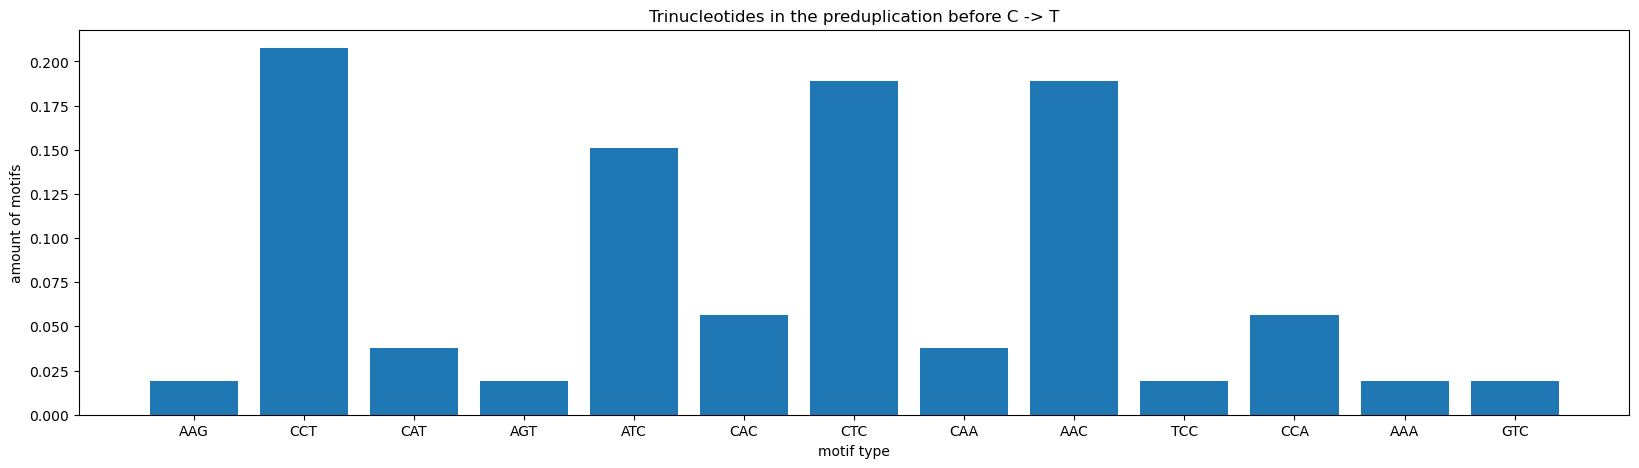

In [47]:
counters = [tc_count_tr, ct_count_tr]
type_ = ["TC", "CT"]
for counter_, typ in zip(counters, type_):
    plt_1 = plt.figure(figsize=(20, 5))
    for mut, freq in for_graph.items():
        if mut == typ:
            values_weighed = [val/freq for val in counter_.values()]
            dinucl = [key[:3] for key in counter_.keys()]
            plt.bar(dinucl, values_weighed)
            plt.title(f"Trinucleotides in the preduplication before {typ[0]} -> {typ[1]}")
            plt.xlabel("motif type")
            plt.ylabel("amount of motifs")
plt.show()

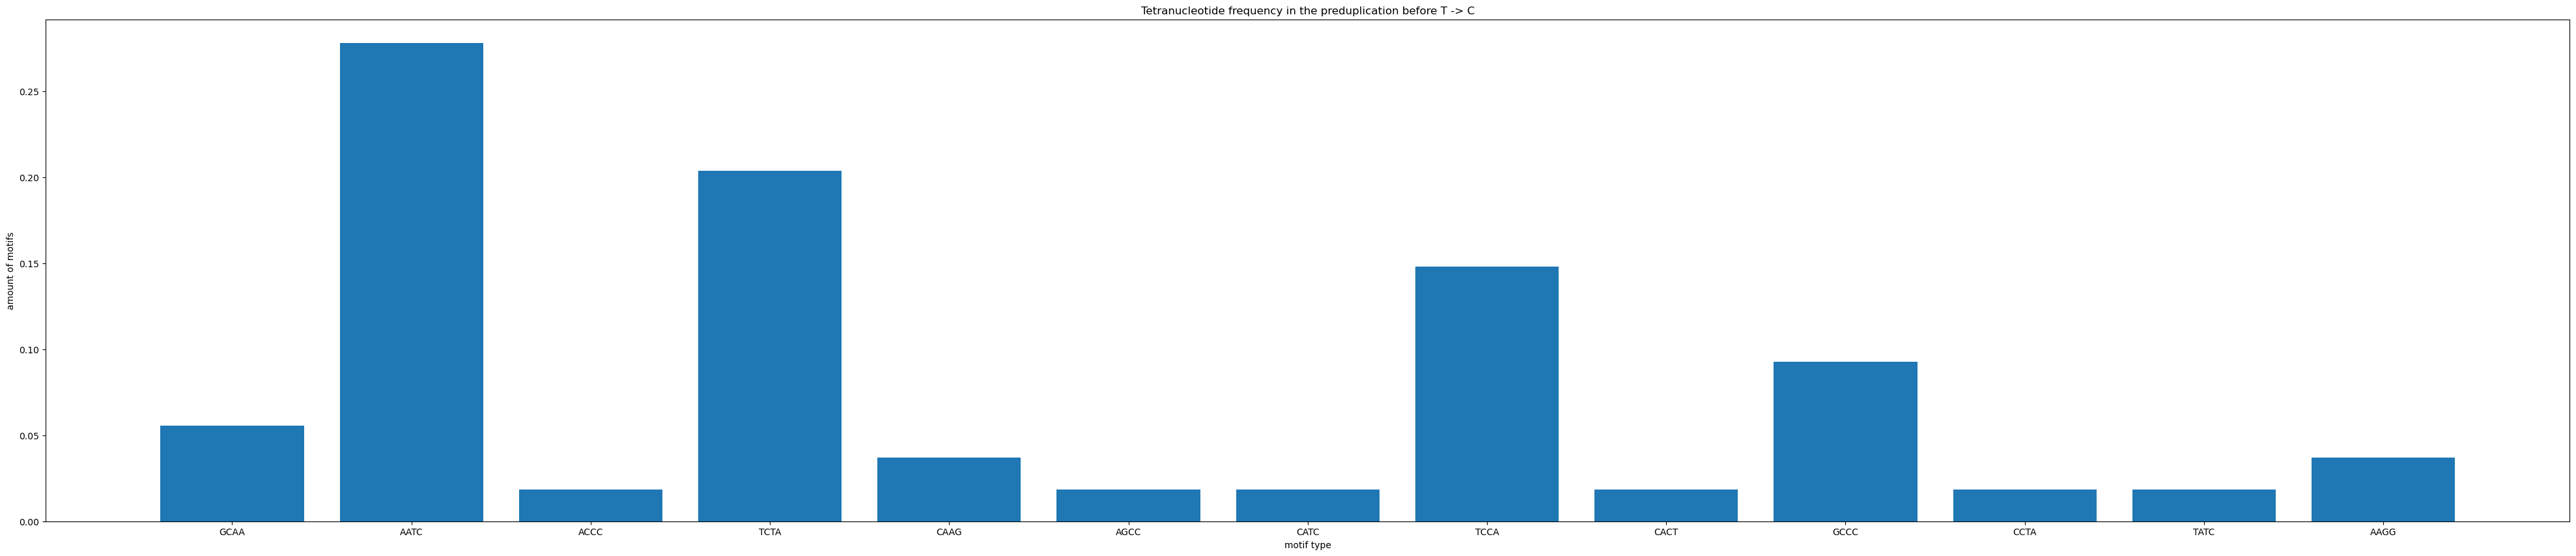

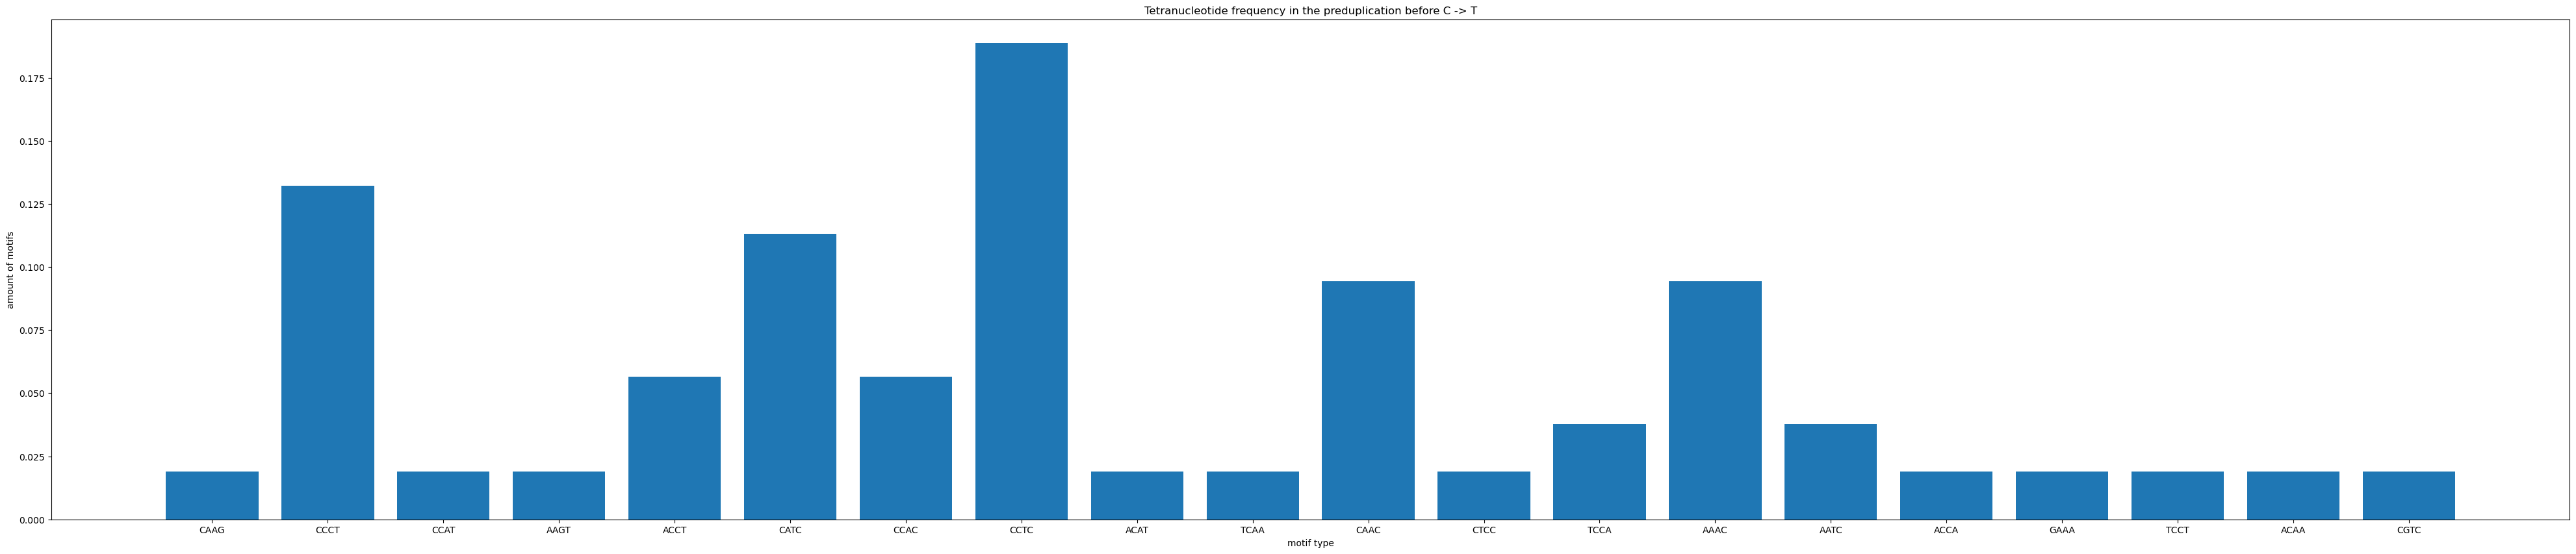

In [46]:
counters = [tc_count_te, ct_count_te]
type_ = ["TC", "CT"]
for counter_, typ in zip(counters, type_):
    plt_1 = plt.figure(figsize=(50, 10))
    for mut, freq in for_graph.items():
        if mut == typ:
            values_weighed = [val/freq for val in counter_.values()]
            dinucl = [key[:4] for key in counter_.keys()]
            plt.bar(dinucl, values_weighed)
            plt.title(f"Tetranucleotide frequency in the preduplication before {typ[0]} -> {typ[1]}")
            plt.xlabel("motif type")
            plt.ylabel("amount of motifs")
plt.show()